<a href="https://colab.research.google.com/github/ANGJIN/UrbanSound8KRNN/blob/master/UrbanSound8K_Classification_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

My UrbanSound8K data is in google drive.  
So, mount google drive first

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Change present working directory to urban sound classification directory  
which is in mounted Google drive.

In [5]:
%cd 'drive/My Drive/urban sound classification'

/content/drive/My Drive/urban sound classification


Import modules

In [6]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import SVG
import keras
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential
from keras.layers import Embedding, LSTM, TimeDistributed, Activation
from keras.layers import Dropout, Dense, Flatten, BatchNormalization

Using TensorFlow backend.


Below, there are some functions to load and pre-process data.

In [0]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

generator function for 'windowing' data.  
returns indices of start and end of each window, size of parameter 'window_size'

In [0]:
def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 20, frames = 41):
    window_size = 512 * (frames - 1)
    mfccs = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            #UrbanSound8K/audio/fold*/*.wav
            label = fn.split('/')[-1].split('-')[1]
            for (start,end) in windows(sound_clip,window_size):
              if len(sound_clip[start:end]) == window_size:
                signal = sound_clip[start:end]
                mfcc = librosa.feature.mfcc(y=signal, sr=s, n_mfcc = bands).T.flatten()[:, np.newaxis].T
                mfccs.append(mfcc)
                labels.append(label)         
    features = np.asarray(mfccs).reshape(len(mfccs),frames,bands)
    return np.array(features), np.array(labels,dtype = np.int)

Read and pre-process all data in each 'fold_'.  
Open and process each wav data with librosa.mfcc module and return list of data and labels.

In [0]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

One hot encoding function. labels returned from extract_features function is like  
[1,3,2,...].  
We have to convert this labels to form of one hot encode data like  
[[0,1,0,0,0,0,...]   
 [0,0,0,1,0,0,...]  
 [0,0,1,0,0,0,...]...].

Now, let's load data!  
We will use data in fold0-6 to train.  
Use data in fold7-9 to validate.  
Use data in fold10 to test model.

In [0]:
parent_dir = 'UrbanSound8K/audio'
tr_features = []
tr_labels = []
ts_features = []
ts_labels = []

for i in range(0,7) :
  sub_dirs = ['fold{}'.format(i)]
  print('start loading 'sub_dirs)
  tmp_features,tmp_labels = extract_features(parent_dir,sub_dirs)
  tmp_labels = one_hot_encode(tmp_labels)
  tr_features.extend(tmp_features)
  tr_labels.extend(tmp_labels)
  print('load complete')

for i in range(7,10) :
  sub_dirs = ['fold{}'.format(i)]
  print('start loading 'sub_dirs)
  tmp_features,tmp_labels = extract_features(parent_dir,sub_dirs)
  tmp_labels = one_hot_encode(tmp_labels)
  ts_features.extend(tmp_features)
  ts_labels.extend(tmp_labels)
  print('load complete')

sub_dirs = ['fold10']
print('start loading 'sub_dirs)
test_features, test_labels = extract_features(parent_dir,sub_dirs)
test_labels = one_hot_encode(test_labels)
print('load complete')

Keep in patience... It requires long time.



---
Use pickle for save and load features.


In [0]:
import pickle
f1=open('tr.pk','wb')
f2=open('ts.pk','wb')
f3=open('test.pk','wb')
tr=[[tr_features],[tr_labels]]
ts=[[ts_features],[ts_labels]]
test=[[test_features],[test_labels]]
pickle.dump(tr,f1)
pickle.dump(ts,f2)
pickle.dump(test,f3)
f1.close()
f2.close()
f3.close()

In [0]:
import pickle
f1=open('tr.pk','rb')
f2=open('ts.pk','rb')
f3=open('test.pk','rb')
tr=pickle.load(f1)
ts=pickle.load(f2)
test=pickle.load(f3)
tr_features=np.array(tr[0][0])
tr_labels=np.array(tr[1][0])
ts_features=np.array(ts[0][0])
ts_labels=np.array(ts[1][0])
test_features=np.array(test[0][0])
test_labels=np.array(test[1][0])
f1.close()
f2.close()
f3.close()

---

Ok, now let's check our data's shape.

In [32]:
print(tr_features.shape, tr_labels.shape)
print(ts_features.shape, ts_labels.shape)
print(test_features.shape, test_labels.shape)

(33503, 41, 20) (33503, 10)
(15337, 41, 20) (15337, 10)
(5218, 41, 20) (5218, 10)


I intend to split data size of train : validate : test to 6:3:1  

In [0]:
# Training Parameters
epochs = 20
batch_size = 50

# Network Parameters
n_input = 20
n_steps = 41
n_hidden = 300
n_classes = 10
use_dropout = False

I build RNN model with 2 layers of LSTM and Dense layer is following after those layers.

In [34]:
model = Sequential()
model.add(LSTM(n_hidden, input_shape=(n_steps,n_input), return_sequences=True))
model.add(LSTM(n_hidden, input_shape=(n_steps,n_input), return_sequences=False))
#model.add(BatchNormalization())
if use_dropout:
    model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

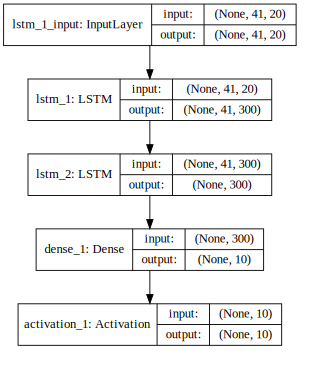

In [35]:
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

Use adam optimizer, categorical crossentropy for loss function and categorical accuracy for metric.

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 41, 300)           385200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3010      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 1,109,410
Trainable params: 1,109,410
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(tr_features,tr_labels,epochs=epochs,batch_size=batch_size,validation_data=(ts_features,ts_labels))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 33503 samples, validate on 15337 samples
Epoch 1/20





33503/33503 [==============================] - 149s 4ms/step - loss: 0.7480 - categorical_accuracy: 0.7487 - val_loss: 1.9681 - val_categorical_accuracy: 0.4904
Epoch 2/20
33503/33503 [==============================] - 140s 4ms/step - loss: 0.4309 - categorical_accuracy: 0.8562 - val_loss: 2.2967 - val_categorical_accuracy: 0.4917
Epoch 3/20
33503/33503 [==============================] - 140s 4ms/step - loss: 0.3051 - categorical_accuracy: 0.8969 - val_loss: 2.1990 - val_categorical_accuracy: 0.5193
Epoch 4/20
33503/33503 [==============================] - 140s 4ms/step - loss: 0.2616 - categorical_accuracy: 0.9114 - val_loss: 2.3001 - val_categorical_accuracy: 0.5173
Epoch 5/20
33503/33503 [==============================] - 139s 4ms/step - loss: 0.2201 - categorical_accuracy: 0.9271 - val_loss: 2.3915 - val_categorical_accur

Training time is average 135 seconds per epoch.

In [38]:
# Evaluating the model on the training and testing set
score = model.evaluate(tr_features, tr_labels, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(test_features, test_labels, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9898815031489717
Testing Accuracy:  0.504024530471445


Training accuracy is 0.98 and it is very high.  
But testing accuracy is 0.5  
Somewhy, model is overfitted to training data.  
Maybe applying regularization and normalization methods can solve this problem.